# Explore and Analyzing Time Series Data

1. Use Residencial Data to Create Time Series 
    + Resample Time Series 
    + Visualize Time Series
* Use Official Weather Data to Create Time Series
* Characteristics of Time Series
    + Seasonality
    + Trend
    + Additive and Multiplicative Models
* Tools to Analyze Time Series
    + Decompose Time Series
    + Test for Stationarity
    + InterpreAutocorrelation 
    + Phophet : https://facebook.github.io/prophet/docs/installation.html#python

In [49]:
import pandas as pd
import datetime
import string
import numpy as np
import matplotlib.pyplot as plt
import plotly
plotly.offline.init_notebook_mode(connected=True)
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from scripts.data import deutsches_wetterdienst, braunschweig
from scripts.plot import plotly_dwd
from scripts.plot import plotly_home

## Use Residencial Data to Create Time Series 

### The Residencial Data Set

This data contains humidity (in percentage) and temperature (in degrees Celsius). The data was collected using four S300 TH devices inside a residence in Braunschweig, Germany during the years 2013-2017. 

There are 4 sensors, positioned in different locations:  outside on the balcony, kitchen, bathroom, and living room. 

Each of the 4 sensors produced temperature and humidity data. The data from sensor 1 is labeled: Temp1 and Humi1; data from sensor 2 is labeled Temp2 and Humi2 ... and so on.


### Creating Time Series with Pandas Datetime

A time series is a sequence of data points indexed (or listed) in temporal order. 

Pandas datetime contains extensive capabilities and features for working with time series data.

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html?highlight=datetime

Have a look at the braunschweig() function inside the data.py script to see how the time series was created.

In [34]:
home = braunschweig('/Users/stewarta/Documents/DATA/htsensor/raw.data')
home.head(10)

,Temp1,Temp2,Temp3,Temp4,Temp8,Humi1,Humi2,Humi3,Humi4
datetime,,,,,,,,,
2013-04-14 07:44:23,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:44:30,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:45:37,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:46:03,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:46:19,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:47:19,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:47:26,10.1,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:50:14,10.2,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0
2013-04-14 07:50:22,10.2,19.6,23.0,20.2,12.2,76.0,42.0,34.0,40.0


## Resample Time Series

Notice that sometimes there are multiple readings per second. Lets resample the data to make the frequency for each
reading equal to a calendar day (abbreviated as D). 


More Resampling Abbreviations: 

http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects


The  ffill() function tells us to replace null if they occur as a result of the resampling by copying the non-null value that occurred before the null In this case the nearest value is used. Other predefined fill methods are: 


More Functions to Handle Resampling Nulls:

https://pandas.pydata.org/pandas-docs/stable/reference/resampling.html#upsampling

In [35]:
frequency = 'M'
home = home.resample(frequency).mean().ffill()
home.head()

,Temp1,Temp2,Temp3,Temp4,Temp8,Humi1,Humi2,Humi3,Humi4
datetime,,,,,,,,,
2013-04-30,13.544393,19.992460,20.174195,20.483871,12.369472,60.408704,42.742337,42.450746,41.185275
2013-05-31,14.802055,20.547485,20.059600,20.727850,14.178162,69.581237,52.965186,53.917487,51.702418
2013-06-30,18.441168,23.070494,22.431911,23.084467,17.681970,64.469329,53.037094,53.877013,51.538462
2013-07-31,22.618148,25.315014,24.911802,25.141685,21.158526,59.502629,52.266523,52.545788,52.005938
2013-08-31,20.488226,24.650944,23.891913,25.040588,19.289692,63.012651,51.371199,52.497329,49.344054


## Visualize Time Series

Not all sensors are in operation throughout the period, so data is missing.

Also, in 2017, the residents moved to a new flat.  A visual inspection of the data reveals that the outside sensor, Temp1, became an inside sensor when the apartment changed. 

Can you detect when the Sensor 1 changed location ?

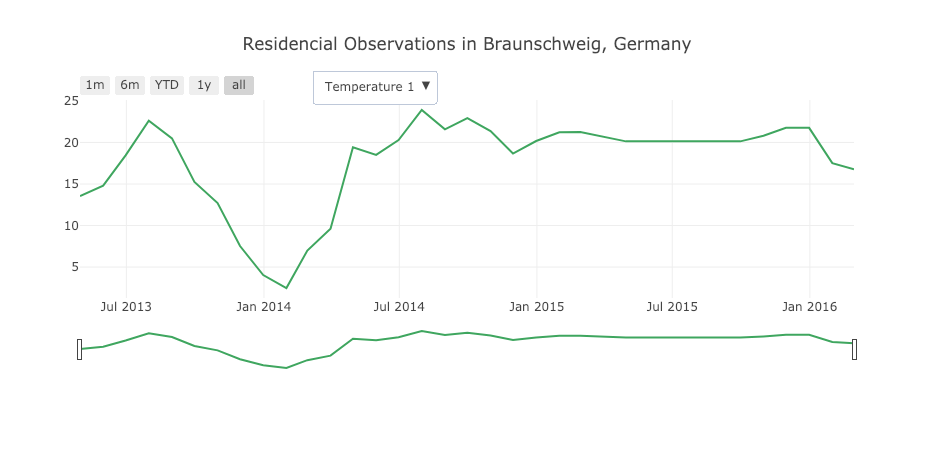

In [43]:
fig = plotly_home(home)
plotly.offline.iplot(fig)

## Use Official Weather Data to Create Time Series

### The Official Wheather Data Set

Given the gaps in the data, the residencial readingy might be problematic for further analysis. 

Deutsches Wetterdienst data set contains temperature and humidity readings in Braunschweig Germany  during the years Jan 1951- Dec 2017. A subset of from 2013 - 2017 is loaded using the deutsches_wetterdienst() script.

What can you say about the data from the Deutsches Wetterdienst?

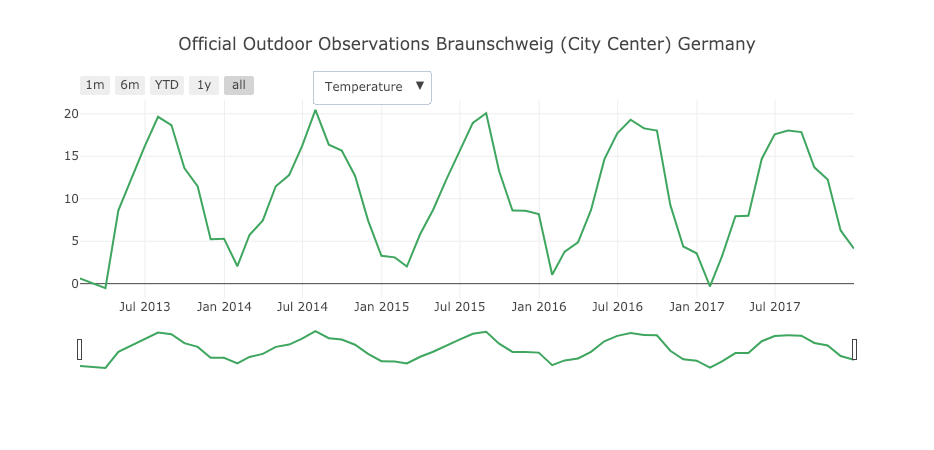

In [42]:
df = deutsches_wetterdienst('/Users/stewarta/Documents/DATA/htsensor/produkt_tu_stunde_19510101_20171231_00662.txt')

# resample
frequency = 'M'
df = df.resample(frequency).mean().ffill()

# plot
fig = plotly_dwd(df)
plotly.offline.iplot(fig)

### Join Residencial Data with Official Weather Data
Lets compare the home readings with an official data source from the Deutsches Wetterdienst.

### How Cool Is That! 

It looks like the sensor data we collected with our Raspberry Pis overlaps nicely with the offical wheather data... well, up to the point ...  

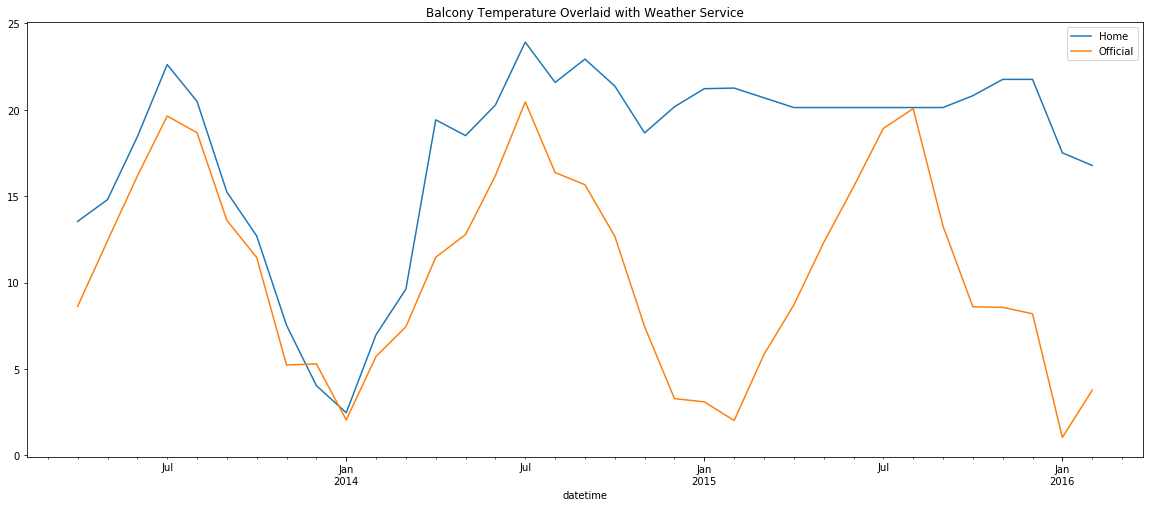

In [38]:
# join the residencial and offical data sets
joined = df.join(home)

# drop nulls
joined.dropna(inplace=True)    

# plot and relab
joined.loc[:,['Temp1','Temp']].rename(columns={'Temp': "Official",'Temp1': "Home"}).plot(figsize=(20,8), title='Balcony Temperature Overlaid with Weather Service')

## Characterists of Time Series

Time series analysis comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. 

To begin our analysis of time series, let's look at some basic characterists of time series:

* Trend: an overall increasing or decreasing behavior of a series over time
* Period:  the time elapsed between two values of the same magnitude
* Seasonality: a repeating patterns or cycles of behavior over time
* Noise: variability in the observations that cannot be explained by seasonality or trend


## Additive and Multiplicative Models

The interactions between trend and seasonality are typically classified as either additive or multiplicative. 

A common additive model is **Australian beer production** because the magnitude of seasonal variation looks constant; it doesn’t change when the time series value increases. 

A common mutiplicative model is **Airline Passenger Numbers** :  As the time series increases, the magnitude of the seasonality increases as well.

<table><tr>
<td>
    <center><b>Additive Model: Australian beer production</b></center> <img src="images/additive-model.png" alt="Drawing" style="width: 500px;"/></td>
<td>
    <center><b>Multiplicative Model: Airline Passenger Numbers</b></center> <img src="images/multiplicative-model.png" alt="Drawing" style="width: 500px;" />
</td>
</tr></table>

## Decompose Time Series

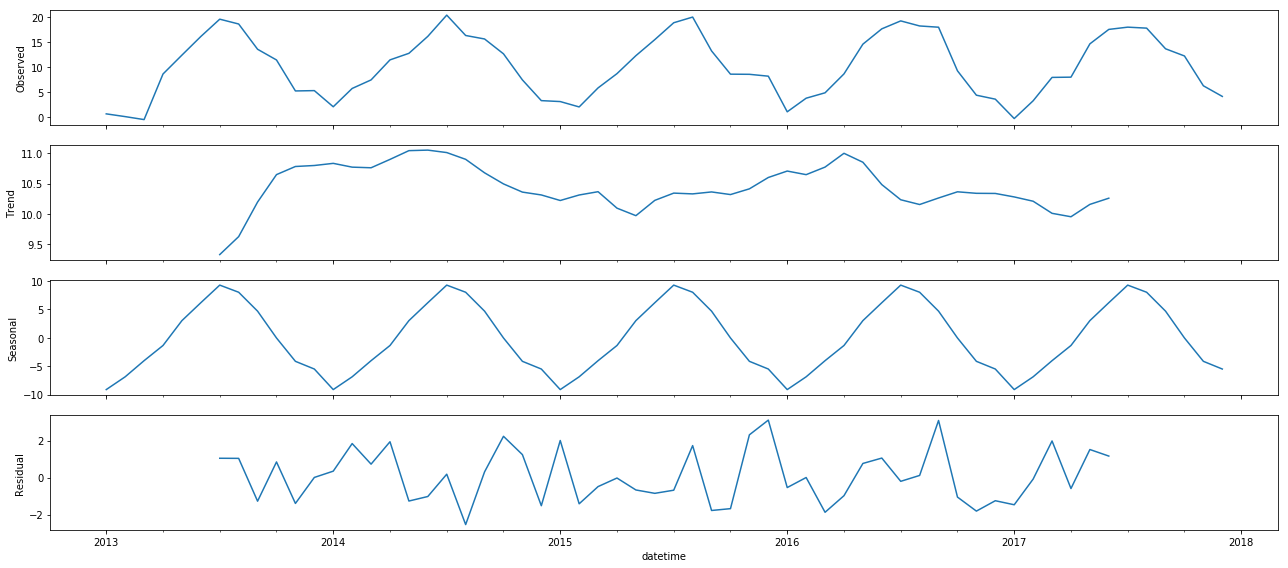

In [45]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df['Temp'])
fig = decomposition.plot()
plt.show()

### Test for Stationarity

A stationary time series is one whose statistical properties such as mean, variance, standard deviation and autocorrelation,  are all constant over time.  

Some prediction algorithms, such as ARIMA, requires a stationary data, before a model can be fit.

The Dickey Fuller test is a popular statistical test used to determine if your time series is stationary or not. 

**Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

**p-value > 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary

**p-value <= 0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary

In [54]:
## Helper function to plot the results of the Dickey Fuller for stationarity 
def test_stationarity(timeseries):

    #Determine rolling statistics
    rolmean = timeseries.rolling(10).mean()
    rolstd =  timeseries.rolling(10).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput )

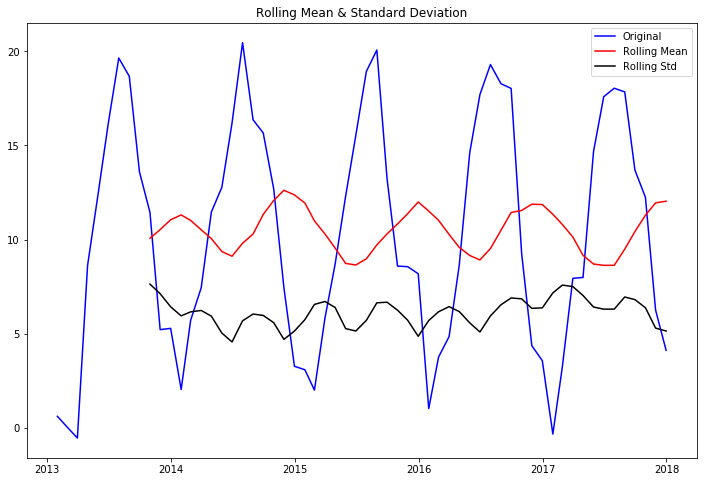

Results of Dickey-Fuller Test:
Test Statistic                 -4.937121
p-value                         0.000030
#Lags Used                      7.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [55]:
# run the Dickey Fuller test for stationarity
test_stationarity(df.Temp)

Looking at the resulting figure we see that the mean and std are  constant over time.  

As part of the tabular output,  We can see that our Test Statistic value of -4.937121 is less than the Critical Value of -3.562879 at 1%. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).  

Rejecting the null hypothesis means that the time series is stationary

## Interpret ACF & PACF Plots

Analysis Stuff

In statistics, prediction is a part of statistical inference. One particular approach to such inference is known as predictive inference, but the prediction can be undertaken within any of the several approaches to statistical inference. Indeed, one description of statistics is that it provides a means of transferring knowledge about a sample of a population to the whole population, and to other related populations, which is not necessarily the same as prediction over time. When information is transferred across time, often to specific points in time, the process is known as forecasting.

Fully formed statistical models for stochastic simulation purposes, so as to generate alternative versions of the time series, representing what might happen over non-specific time-periods in the future
Simple or fully formed statistical models to describe the likely outcome of the time series in the immediate future, given knowledge of the most recent outcomes (forecasting).
Forecasting on time series is usually done using automated statistical software packages and programming languages, such as Mathematica, R, S, SAS, SPSS, Minitab, pandas (Python) and many others.
Forecasting on large scale data is done using Spark which has spark-ts as a third party package
* Autocorrelation analysis to examine serial dependence


Time series forecasting is the use of a model to predict future values based on previously observed values. While regression analysis is often employed in such a way as to test theories that the current values of one or more independent time series affect the current value of another time series, this type of analysis of time series is not called "time series analysis", which focuses on comparing values of a single time series or multiple dependent time series at different points in time.[1] Interrupted time series analysis is the analysis of interventions on a single time series.